In [11]:
import numpy as np
import matplotlib.pyplot as plt

hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass
C = 1.0

L = 10.0  # Length of the system
T = 10.0  # Time of the simulation
dx = 0.1  # Spatial step size
dt = 0.1  # Time step size
x0 = L/4  # Initial position

# Initial wave function
def psi0(x, C, x0):
    w = (C/m)**0.5
    return (m * w / (np.pi * hbar))**0.25 * np.exp(-0.5 * m * w * (x - x0)**2 / hbar)

# Potential function
def potential(x, x0, C):
    return 0.5 * C * (np.abs(x) - x0)**2

# Split operator method
def split_operator(x0, C, dx, dt):
    x = np.arange(-L, L, dx)
    N = len(x)
    # Initialize wave function
    psi = psi0(x, C, x0)
    Psi = []
    t = 0.0 # Initialize time
    while t < T:
        Psi.append((t, psi))
        # Kinetic evolution
        psi = np.fft.ifft(np.exp(-0.5j * dt * (hbar / m) * (np.fft.fftfreq(N, dx) ** 2)) * np.fft.fft(psi))
        
        # Potential evolution
        psi *= np.exp(-1j * dt * potential(x, x0, C) / hbar)
        
        # Kinetic evolution
        psi = np.fft.ifft(np.exp(-0.5j * dt * (hbar / m) * (np.fft.fftfreq(N, dx) ** 2)) * np.fft.fft(psi))
        
        # Update time
        t += dt
    return Psi

Psi = split_operator(x0, C, dx, dt)

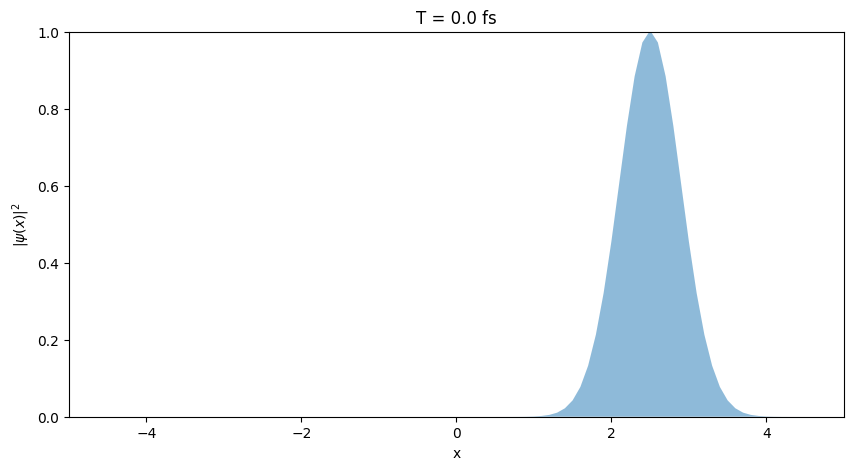

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

def animate(i):
    x = np.arange(-L, L, dx)
    ax.clear()
    fig.set_size_inches(10, 5)
    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(0, 1)
    #ax.plot(x, np.abs(Psi[i][1])**2)
    # Plot the probability density
    ax.fill_between(x, 0, np.abs(Psi[i][1])**2, alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('$|\psi(x)|^2$')
    ax.set_title('T = %.1f fs' % (Psi[i][0]))

ani = FuncAnimation(fig, animate, frames=len(Psi), interval=dt/1000)
# Save animation as a GIF file
ani.save('ex4.gif', writer='pillow')
